This notebook summarizes the work we carried out in the “Statistical Design of Experiments” course on our information system for finding the “Optimal Bus Stop.”
Goal: examine how different factors—user type, interface versions, and advertising levels—affect usage patterns and engagement, while demonstrating how experimental design supports data‑driven decision‑making.
The notebook briefly covers the data‑collection process, the key statistical tests we ran (both parametric and non‑parametric), and the preliminary conclusions, as a continuation of earlier projects in which the system itself was developed.

In [1]:
pip install numpy pandas scipy statsmodels matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
# -------------------------------------------------
# 1) Wilcoxon (Mann‑Whitney U) rank‑sum test
# -------------------------------------------------
import numpy as np
import pandas as pd
from scipy.stats import rankdata, mannwhitneyu
import matplotlib.pyplot as plt

# ─── Data ─────────────────────────────────────────
business_times = np.array([
    28.902, 29.838, 44.583, 74.741, 14.903, 48.046, 3.640, 2.041, 8.233, 4.180,
    66.153, 61.137, 26.167, 97.545, 34.284, 2.334, 19.276, 9.274, 9.450, 40.347,
    55.745, 66.907, 25.839, 54.351, 66.835, 35.598, 49.199, 60.501, 53.499, 44.905
])

private_times = np.array([
    1.402, 44.268, 24.734, 23.148, 22.039, 41.423, 5.118, 4.440, 30.212, 10.938,
    23.627, 23.939, 11.926, 0.116, 3.890, 40.517, 21.461, 29.880, 12.489, 10.297,
    5.436, 15.591, 29.696, 38.859, 38.162, 14.318, 28.007, 29.022, 0.917, 0.741
])


In [4]:
# ─── Ranks and tables ─────────────────────────────
all_times = np.concatenate([business_times, private_times])
ranks = rankdata(all_times)                     # average‑rank method (default)

business_ranks = ranks[:len(business_times)]
private_ranks  = ranks[len(business_times):]

business_table = pd.DataFrame({"Value": business_times, "Rank": business_ranks})
private_table  = pd.DataFrame({"Value": private_times,  "Rank": private_ranks})

print("Business Table (Treatment Group):")
print(business_table.to_string(index=False))
print("\nPrivate Table (Control Group):")
print(private_table.to_string(index=False))

# ─── Rank sums & Wilcoxon statistic ───────────────
sum_business_ranks = business_ranks.sum()
sum_private_ranks  = private_ranks.sum()
W = sum_business_ranks      # same definition as in the R script

print("\nSum of Ranks for Business (Treatment) Group (W):")
print(sum_business_ranks)
print("Sum of Ranks for Private (Control) Group:")
print(sum_private_ranks)
print("Wilcoxon rank‑sum statistic (W) for Treatment Group:")
print(W)

# Mann‑Whitney U (one‑sided, Business > Private)
mw = mannwhitneyu(business_times, private_times,
                  alternative="greater", method="auto")
print("\np‑value:")
print(mw.pvalue)


Business Table (Treatment Group):
 Value  Rank
28.902  33.0
29.838  36.0
44.583  47.0
74.741  59.0
14.903  21.0
48.046  49.0
 3.640   7.0
 2.041   5.0
 8.233  13.0
 4.180   9.0
66.153  56.0
61.137  55.0
26.167  31.0
97.545  60.0
34.284  39.0
 2.334   6.0
19.276  23.0
 9.274  14.0
 9.450  15.0
40.347  43.0
55.745  53.0
66.907  58.0
25.839  30.0
54.351  52.0
66.835  57.0
35.598  40.0
49.199  50.0
60.501  54.0
53.499  51.0
44.905  48.0

Private Table (Control Group):
 Value  Rank
 1.402   4.0
44.268  46.0
24.734  29.0
23.148  26.0
22.039  25.0
41.423  45.0
 5.118  11.0
 4.440  10.0
30.212  38.0
10.938  17.0
23.627  27.0
23.939  28.0
11.926  18.0
 0.116   1.0
 3.890   8.0
40.517  44.0
21.461  24.0
29.880  37.0
12.489  19.0
10.297  16.0
 5.436  12.0
15.591  22.0
29.696  35.0
38.859  42.0
38.162  41.0
14.318  20.0
28.007  32.0
29.022  34.0
 0.917   3.0
 0.741   2.0

Sum of Ranks for Business (Treatment) Group (W):
1114.0
Sum of Ranks for Private (Control) Group:
716.0
Wilcoxon rank‑sum stati

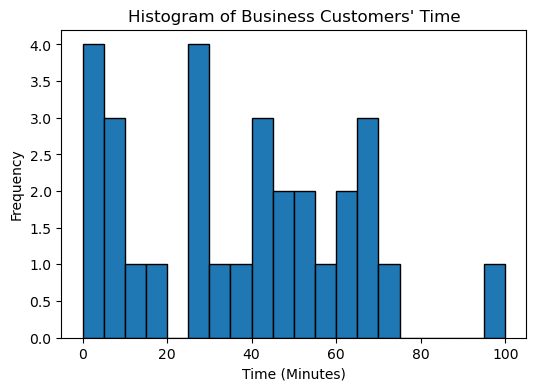

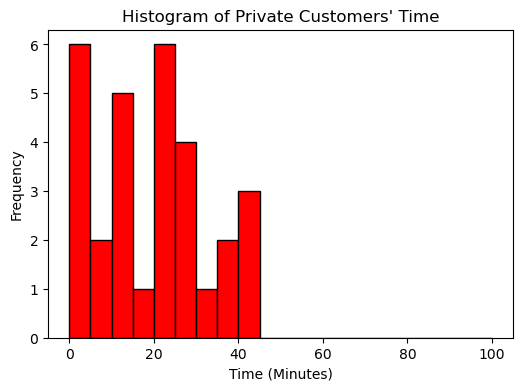

In [5]:
# ─── Histograms ───────────────────────────────────
business_df = pd.DataFrame({"Time": business_times, "Group": "Business"})
private_df  = pd.DataFrame({"Time": private_times,  "Group": "Private"})

plt.figure(figsize=(6,4))
plt.hist(business_df["Time"], bins=np.arange(0,105,5),
         edgecolor="black")
plt.title("Histogram of Business Customers' Time")
plt.xlabel("Time (Minutes)")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(private_df["Time"], bins=np.arange(0,105,5),
         color="red", edgecolor="black")
plt.title("Histogram of Private Customers' Time")
plt.xlabel("Time (Minutes)")
plt.ylabel("Frequency")
plt.show()


In [6]:
# -------------------------------------------------
# 2) Kruskal‑Wallis + pairwise Mann–Whitney (Bonferroni)
# -------------------------------------------------
from scipy.stats import kruskal
from itertools import combinations
from math import comb

# ─── Data ─────────────────────────────────────────
no_ads = np.array([
 10.910426,15.561102,6.865332,16.816735,12.036599,11.074526,9.235844,14.019198,
 16.605989,8.53958 ,13.990956,12.458635,13.969508,5.749338 ,20.555771,15.560616,
 12.822838,10.998519,10.861199,26.022371,9.858811 ,16.46454 ,6.936202 ,13.495255,
 20.765864,15.19426 ,10.179336,13.424993,9.695641 ,16.38632 ,14.347485,10.085348,
 7.359394 ,17.409943,20.475123,12.946939,12.18728 ,20.25693 ,28.747548,18.109904,
 11.695533,10.36135 ,5.744757 ,13.571816,5.984752 ,14.6498  ,26.548023,23.738965,
 10.585279,5.165127
])
one_ad = np.array([
 11.54809 ,11.383742,10.275162,4.833045 ,18.724999,14.991075,8.686356 ,13.123084,
 12.243153,6.099292 ,8.729078 ,11.692964,10.925971,10.301431,14.193507,9.752087 ,
 8.885271 ,11.013575,7.88896 ,4.898116 ,9.965529 ,10.806307,21.539488,12.621662,
 11.996935,14.626971,5.420667 ,22.684985,11.580494,10.003072,12.450891,14.014844,
 6.257545 ,10.94009 ,6.000833 ,8.976955 ,7.568665 ,17.614499,9.319927 ,16.780073,
 4.424761 ,10.676419,14.135946,9.535063 ,5.921428 ,16.137836,4.065748 ,12.9494949,
 9.964397 ,6.457161
])
multiple_ads = np.array([
 11.5156379,11.6983191,16.5899647,3.1628259 ,11.0691928,18.5414088,14.0256515,
 6.7636461 ,9.1691184 ,1.7975339 ,5.0571122 ,5.5626052 ,8.2817883 ,7.7162257 ,
 7.6573207 ,7.5346916 ,10.3439236,19.0278045,10.2807322,17.6746807,4.8588873 ,
 23.2162253,2.2266586 ,1.8850426 ,3.6847818 ,3.0166163 ,19.2847537,16.4441389,
 2.3955034 ,6.7320785 ,27.0505139,5.3557042 ,19.6948929,6.1353454 ,0.4590271 ,
 7.8468755 ,18.3871161,11.0015708,16.3722439,5.6986586 ,3.3310525 ,7.4371322 ,
 8.0869403 ,5.9776815 ,0.9268776 ,21.8404065,7.4688799 ,12.165883 ,7.8173745 ,
 11.8706076
])


In [7]:
# ─── Combined DataFrame ───────────────────────────
data_kw = pd.DataFrame({
    "Time": np.concatenate([no_ads, one_ad, multiple_ads]),
    "Advertising": (["No Ads"]        * len(no_ads)       +
                    ["One Ad"]       * len(one_ad)       +
                    ["Multiple Ads"] * len(multiple_ads))
})

print("\nData for Level 1 (No Ads):")
print(data_kw[data_kw.Advertising == "No Ads"].head())
print("\nData for Level 2 (One Ad):")
print(data_kw[data_kw.Advertising == "One Ad"].head())
print("\nData for Level 3 (Multiple Ads):")
print(data_kw[data_kw.Advertising == "Multiple Ads"].head())

# ─── Ranks for display (optional) ────────────────
data_kw["Rank"] = rankdata(data_kw["Time"])

# ─── Kruskal‑Wallis omnibus test ────────────────
kw_stat, kw_p = kruskal(no_ads, one_ad, multiple_ads)
print("\nKruskal‑Wallis Test Result:")
print(f"Statistic = {kw_stat:.4f}, p‑value = {kw_p:.6f}")

# ─── Bonferroni‑adjusted pairwise U‑tests ───────
alpha = 0.05
m = comb(3, 2)               # number of pairwise comparisons = 3
alpha_bonferroni = alpha / m / 2   # identical to R script division by 2

print("\nBonferroni‑adjusted alpha:")
print(alpha_bonferroni)

def perform_mann_whitney(group1_name, group2_name):
    group1 = data_kw.loc[data_kw.Advertising == group1_name, "Time"].values
    group2 = data_kw.loc[data_kw.Advertising == group2_name, "Time"].values
    
    # manual U (same loop as R)
    U = sum((g2 < g1).sum() for g1 in group1 for g2 in group2)
    print(f"\nU value for comparison between {group1_name} and {group2_name}: {U}")
    
    stat, p = mannwhitneyu(group1, group2, alternative="two-sided", method="auto")
    print(f"Comparison between {group1_name} (X) and {group2_name} (Y):")
    print(f"U statistic (SciPy) : {stat}")
    print(f"p‑value             : {p}")
    print(f"Bonferroni alpha    : {alpha_bonferroni}")
    if p < alpha_bonferroni:
        print("→ Reject the null hypothesis (significant difference).")
    else:
        print("→ Fail to reject the null hypothesis (no significant difference).")

perform_mann_whitney("No Ads",       "One Ad")
perform_mann_whitney("No Ads",       "Multiple Ads")
perform_mann_whitney("One Ad",       "Multiple Ads")




Data for Level 1 (No Ads):
        Time Advertising
0  10.910426      No Ads
1  15.561102      No Ads
2   6.865332      No Ads
3  16.816735      No Ads
4  12.036599      No Ads

Data for Level 2 (One Ad):
         Time Advertising
50  11.548090      One Ad
51  11.383742      One Ad
52  10.275162      One Ad
53   4.833045      One Ad
54  18.724999      One Ad

Data for Level 3 (Multiple Ads):
          Time   Advertising
100  11.515638  Multiple Ads
101  11.698319  Multiple Ads
102  16.589965  Multiple Ads
103   3.162826  Multiple Ads
104  11.069193  Multiple Ads

Kruskal‑Wallis Test Result:
Statistic = 14.0056, p‑value = 0.000909

Bonferroni‑adjusted alpha:
0.008333333333333333

U value for comparison between No Ads and One Ad: 1645
Comparison between No Ads (X) and One Ad (Y):
U statistic (SciPy) : 1645.0
p‑value             : 0.006535856859032361
Bonferroni alpha    : 0.008333333333333333
→ Reject the null hypothesis (significant difference).

U value for comparison between No Ads a

In [8]:
# -------------------------------------------------
# 3) Two‑factor (Screen × Day) ANOVA with blocks
# -------------------------------------------------
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import f as f_dist

# ─── Data ─────────────────────────────────────────
df_anova = pd.DataFrame({
    "Screen": np.repeat(np.arange(1,4), 3).astype(str),
    "Day":    np.tile  (np.arange(1,4), 3).astype(str),
    "Time":   [22, 21.66667, 27.55556,
               24.5, 23.6,    24.22222,
               23.33333, 24.2, 25]
})

print("\nBlock‑design data:")
print(df_anova)

# ─── Classical ANOVA table (like R's aov) ────────
model = smf.ols("Time ~ C(Screen) + C(Day)", data=df_anova).fit()
anova_tbl = sm.stats.anova_lm(model, typ=2)
print("\nANOVA summary (statsmodels):")
print(anova_tbl)

# ─── Manual sums‑of‑squares (exactly as in R) ────
Y_all = df_anova["Time"].sum()
N = len(df_anova)
c = df_anova["Screen"].nunique()   # columns
r = df_anova["Day"].nunique()      # rows

Y_i = df_anova.groupby("Day")["Time"].sum()     # by rows
Y_j = df_anova.groupby("Screen")["Time"].sum()  # by columns

SST = (df_anova["Time"]**2).sum() - (Y_all**2) / N
SSR = (Y_i**2).sum() / c - (Y_all**2) / N
SSC = (Y_j**2).sum() / r - (Y_all**2) / N
SSE = SST - SSR - SSC

df_rows    = r - 1
df_columns = c - 1
df_error   = N - r - c + 1

MSR = SSR / df_rows
MSC = SSC / df_columns
MSE = SSE / df_error

F_rows    = MSR / MSE
F_columns = MSC / MSE

print("\n--- Manual ANOVA components ---")
print(f"Y.. (sum of all observations): {Y_all}")
print(f"Y.i (row sums):\n{Y_i}")
print(f"Y.j (column sums):\n{Y_j}")
print(f"\nSST = {SST:.5f}")
print(f"SSR = {SSR:.5f}")
print(f"SSC = {SSC:.5f}")
print(f"SSE = {SSE:.5f}")

print(f"\nDegrees of freedom — rows: {df_rows}, columns: {df_columns}, error: {df_error}")
print(f"MSR = {MSR:.5f}")
print(f"MSC = {MSC:.5f}")
print(f"MSE = {MSE:.5f}")

print(f"\nF (rows)    = {F_rows:.5f}")
print(f"F (columns) = {F_columns:.5f}")

alpha = 0.05
Fcrit_rows    = f_dist.ppf(1 - alpha, df_rows,   df_error)
Fcrit_columns = f_dist.ppf(1 - alpha, df_columns, df_error)

print(f"\nF critical value for rows    (α={alpha}) = {Fcrit_rows:.5f}")
print(f"F critical value for columns (α={alpha}) = {Fcrit_columns:.5f}")

if F_rows > Fcrit_rows:
    print("→ Reject null hypothesis for rows")
else:
    print("→ Accept null hypothesis for rows")

if F_columns > Fcrit_columns:
    print("→ Reject null hypothesis for columns")
else:
    print("→ Accept null hypothesis for columns")


Block‑design data:
  Screen Day      Time
0      1   1  22.00000
1      1   2  21.66667
2      1   3  27.55556
3      2   1  24.50000
4      2   2  23.60000
5      2   3  24.22222
6      3   1  23.33333
7      3   2  24.20000
8      3   3  25.00000

ANOVA summary (statsmodels):
              sum_sq   df         F    PR(>F)
C(Screen)   0.330392  2.0  0.053346  0.948715
C(Day)     11.312462  2.0  1.826544  0.273179
Residual   12.386741  4.0       NaN       NaN

--- Manual ANOVA components ---
Y.. (sum of all observations): 216.07778
Y.i (row sums):
Day
1    69.83333
2    69.46667
3    76.77778
Name: Time, dtype: float64
Y.j (column sums):
Screen
1    71.22223
2    72.32222
3    72.53333
Name: Time, dtype: float64

SST = 24.02959
SSR = 11.31246
SSC = 0.33039
SSE = 12.38674

Degrees of freedom — rows: 2, columns: 2, error: 4
MSR = 5.65623
MSC = 0.16520
MSE = 3.09669

F (rows)    = 1.82654
F (columns) = 0.05335

F critical value for rows    (α=0.05) = 6.94427
F critical value for columns (